# Comparing meta-learners with different ensembles of trees as base learners

## Introduction

Meta-learners are a class of models used for estimating the effectiveness of a certain treatement and they are used when the effectiveness of a treatement is assumed to be *heterogeneous*, that is the effect of the treatement might vary across individuals. In particular, they estimate the treatement effectiveness by decomposing the problem to several subregressions. The models used for these subregressions will be called *base learners*. Some of the most popular base learners are tree based ensembles, in particular Random Forest and Bayesian Additive Regression Trees (BART) due to their flexibility, however any machine learning algorithm suitable for regression problems can be used.

Following [1], we will denote by $Y$ an outcome vector, by $X_i \in \mathbb{R}^d$ a feature vector containing potential confounders for the $i$th unit, by $W_i \in \{0, 1\}$ the treatment assignment indicator and by  $Y_i (0) \in \mathbb{R}$ and $Y_i(1) \in \mathbb{R}$ the potential outcome of the $i$th unit when assigned to the control and the treatement group respectively. With this notation

$$ Y = W Y(1) + (1 - W) Y(0). $$

Our task is to estimate the *conditional average treatement effect (CATE)*, defined as 
$$\tau(x) = \mathbb{E}\left[Y(1) - Y(0) \mid X=x\right].$$

The goal of this notebook is to introduce several meta-learners and compare their performance estimating CATE. The evaluation of an estimation $\hat{\tau}$ of $\tau$ will be based on *expected mean squared error* defined as 
$$\operatorname{EMSE}(\tau) = \mathbb{E}\left[\left(\tau(X) - \hat{\tau}(X)\right)^2\right].$$

## The fundamental problem of causal inference

The fact that only one of the potential outcomes ever materializes, means that CATE is never directly observed, thus on real world data, EMSE cannot be computed. This is often refered to as *the fundamental problem of causal inference*. To get around this problem, in this notebook we will deal with synthetic data with data generating process of the form
$$y = 10\sigma(\alpha X) + W \sigma(\beta X) + \varepsilon,$$
where $\varepsilon_i \sim N(0, 1)$ and $W_i \sim \operatorname{Bernoulli}\left(\frac14\right)$ are i.i.d. and $$\sigma(x) = \frac{e^x}{1 + e^x}$$ is the sigmoid function (applied coordinatewise).
Here, CATE can be expressed as $\tau(X) = \sigma(\beta X)$.

In [24]:
import numpy as np
import pandas as pd
from causalpy.skl_meta_learners import SLearner, TLearner, XLearner, DRLearner
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor

np.random.seed(42)

def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

def create_synthetic_data(*shape):
    X = np.random.rand(*shape)

    α = np.random.rand(shape[1])
    β = np.random.rand(shape[1])

    treatment = np.random.binomial(n=1, p=.25, size=shape[0])
    treatment_effect = sigmoid(X @ β)

    noise = np.random.rand(shape[0])

    y = 10 * sigmoid(X @ α) + treatment_effect * treatment + noise

    X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(shape[1])])
    y = pd.Series(y, name='target')
    treated = pd.Series(treatment, name='treatment')
    return X, y, treated, treatment_effect

X, y, treated, treatment_effect = create_synthetic_data(1000, 10)

## S-learner

The simplest meta-learner is the *S-learner*, which treats the treatement assignment indicator as a feature and estimates 

$$\mu(x, w) := \mathbb{E}[Y \mid X=x, W=w]$$

with an appropriate base learner. The "S" in S-learner stands for "single", as it uses a single model to estimate CATE. We will denote this estimation with $\hat{\mu}(x, w)$. Then the S-learner approximates CATE as  

$$\hat{\tau_S}(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0).$$

In the following example we will choose `HistGradientBoostingRegressor` as base learner.

In [25]:
%%time
# Utility for printing some statistics.
def summarize_learner(learner):
    learner.summary(n_iter=100)
    print(f"Actual average treatement effect: {treatment_effect.mean()}")
    print(f"EMSE: {mean_squared_error(treatment_effect, learner.cate)}")

slearner = SLearner(
    X=X,
    y=y,
    treated=treated,
    model=HistGradientBoostingRegressor()
)

summarize_learner(slearner)

Number of observations:             1000
Number of treated observations:     261
Average treatement effect (ATE):    0.8825372188727141
95% Confidence interval for ATE:    (0.5336478252676806, 1.3368338911656805)
Estimated bias:                     -0.005333370586446671
Actual average treatement effect: 0.8686759437628603
EMSE: 0.0489448259669642
CPU times: total: 8min 50s
Wall time: 1min 11s


**TODO: Do some plotting. As of now it plots the distribution of the CATE estimates. While that is not totally uninteresting, it is not good either.**

More ideas: 
- feature to estimated CATE scatter plot?
- several SHAP related things?
- ...?

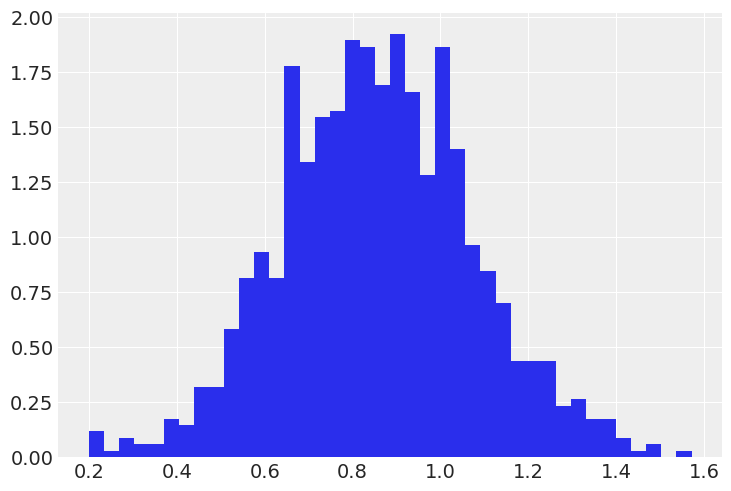

In [26]:
slearner.plot()

Eventough, the S-learner performs quite well in our synthetic example, it has some limitations. Most importantly, since the treatement indicator is included in the regression as an ordinary variable, it's effect may get lost, especially if the base learner is a tree based ensemble.

## T-learner

The *T-learner* solves the issue mentioned above by predicting $Y(0)$ and $Y(1)$ in two different regressions. Namely, we estimate
$$\mu_{\operatorname{treated}}(x) := \mathbb{E}[Y(1) \mid X=x], \quad \text{and} \quad \mu_{\operatorname{untreated}}(x) := \mathbb{E}[Y(0) \mid X=x]$$
separately and define estimate the cate as
$$\hat{\tau}_T(x) = \hat{\mu}_{\operatorname{treated}}(x) - \hat{\mu}_{\operatorname{untreated}}(x),$$
where $\hat{\mu}_{\operatorname{treated}}$ and $\hat{\mu}_{\operatorname{untreated}}$ are the estimated functions. 

Again, we will choose *both* models to be `HistGradientBoostingRegressor`.

In [28]:
%%time
tlearner = TLearner(
    X=X,
    y=y,
    treated=treated,
    model=HistGradientBoostingRegressor()
)


summarize_learner(tlearner)

Number of observations:             1000
Number of treated observations:     261
Average treatement effect (ATE):    0.8778680189940496
95% Confidence interval for ATE:    (0.44254662378948145, 1.4724386927005046)
Estimated bias:                     0.0075568485724106125
Actual average treatement effect: 0.8686759437628603
EMSE: 0.09250244262195867
CPU times: total: 11min 16s
Wall time: 1min 32s


# X-learner
The X-learner performs better than other CATE estimators when
- one of the treatement groups is significantly larger than the other one, 
- when the CATE function has structural properties such as sparsity or smoothness, it can provably adapt [1].

Very similarly, to the T-learner, the X-learner first estimates $\mu_{\operatorname{treated}}$ and $\mu_{\operatorname{untreated}}$. Next, it computes 

$$D(1) := Y(1) - \hat{\mu}_{\operatorname{untreated}}(X(1)), \quad \text{and} \quad D(0) = \hat{\mu}_{\operatorname{treated}}(X(0)) - Y(0).$$

Note that if $\hat{\mu}_{\operatorname{untreated}} = \mu_{\operatorname{untreated}}$ and $\hat{\mu}_{\operatorname{treated}} = \mu_{\operatorname{treated}}$, then $\tau(x) = \mathbb{E}[D(1) | X=x] = \mathbb{E}[D(0) | X=x]$, so CATE can be estimated by regressing onto $D(0)$ or $D(1)$. Let us denote these estimations by $\tau_0$ and $\tau_1$, respectively. 

Finally, the X-learner computes a weighted average of the two CATE estimates, that is 
$$\hat{\tau}_X(x) = g(x)\hat{\tau}_0 + (1 - g(x))\hat{\tau_1}(x),$$
for some weight function $g: \mathbb{R}^d \rightarrow [0, 1]$.

In [29]:
%%time
xlearner = XLearner(X=X, y=y, treated=treated, model=HistGradientBoostingRegressor())

summarize_learner(xlearner)

Number of observations:             1000
Number of treated observations:     261
Average treatement effect (ATE):    0.8656013308211011
95% Confidence interval for ATE:    (0.5670698664248546, 1.2446227193486425)
Estimated bias:                     -0.0031460678827127334
Actual average treatement effect: 0.8686759437628603
EMSE: 0.03875185597434108
CPU times: total: 22min 8s
Wall time: 3min 2s


In CausalPy, we obtain $g$ as an estimation of the so-called *propensity score*, that is the conditional probability of a unit receiving treatment given $X$. By default, we use logistic regression to obtain this estimation. However, in case one of the treatement groups is much larger than the other one, it makes sense to set $g \equiv 0$ or $g \equiv 1$. This can be done the following way. 

In [37]:
%%time
from sklearn.dummy import DummyClassifier

xlearner_mf = XLearner(
    X=X,
    y=y,
    treated=treated,
    model=HistGradientBoostingRegressor(),
    propensity_score_model=DummyClassifier(strategy="most_frequent")
)

summarize_learner(xlearner_mf)

Number of observations:             1000
Number of treated observations:     261
Average treatement effect (ATE):    0.8285314927602266
95% Confidence interval for ATE:    (0.5295382157583198, 1.275838462466607)
Estimated bias:                     -0.010891457791703623
Actual average treatement effect: 0.8686759437628603
EMSE: 0.03875185597434108
CPU times: total: 22min 37s
Wall time: 3min 2s


In [38]:
%%time
from xgboost import XGBClassifier

xlearner_mf = XLearner(
    X=X,
    y=y,
    treated=treated,
    model=HistGradientBoostingRegressor(),
    propensity_score_model=XGBClassifier()
)

summarize_learner(xlearner_mf)

Number of observations:             1000
Number of treated observations:     261
Average treatement effect (ATE):    0.8257963466324518
95% Confidence interval for ATE:    (0.6015347065733898, 1.2304421938761037)
Estimated bias:                     -0.005635485886235879
Actual average treatement effect: 0.8686759437628603
EMSE: 0.03875185584711515
CPU times: total: 29min 2s
Wall time: 4min 7s


# DR-learner
The DR-learner ...

In [35]:
%%time
drlearner = DRLearner(X=X, y=y, treated=treated, model=HistGradientBoostingRegressor())

summarize_learner(drlearner)

Number of observations:             1000
Number of treated observations:     261
Average treatement effect (ATE):    0.8617951727930917
95% Confidence interval for ATE:    (0.4540090400090874, 1.4731133930096414)
Estimated bias:                     0.001972318343075466
Actual average treatement effect: 0.8686759437628603
EMSE: 0.1859824363704813
CPU times: total: 11min 25s
Wall time: 1min 32s


In [19]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor

In [22]:
def compute_emse(learner, m):
    l = learner(X_train, y_train, treated_train, m)
    return mean_squared_error(effect_train, l.cate)

In [26]:
models = [
    ("Random forest", RandomForestRegressor()),
    ("Hist gradient boosting", HistGradientBoostingRegressor()),
    ("AdaBoost", AdaBoostRegressor()),
    ("XGBoost", XGBRegressor()),
    ("LightGBM", LGBMRegressor())
]
bench = pd.DataFrame({
    m_name: {
            'SLearner':  compute_emse( SLearner, m),
            'TLearner':  compute_emse( TLearner, m),
            'XLearner':  compute_emse( XLearner, m),
            'DRLearner': compute_emse(DRLearner, m)
        } for m_name, m in models
})

In [27]:
bench

,Random forest,Hist gradient boosting,AdaBoost,XGBoost,LightGBM
SLearner,0.043266,0.028720,0.005436,0.048527,0.030729
TLearner,0.045308,0.055968,0.011586,0.109095,0.052863
XLearner,0.027551,0.042998,0.008828,0.069227,0.041362
DRLearner,0.164998,0.179821,0.279397,0.109630,0.184410


# TODO: EMSE as a function of population size